In [96]:
import os
import tensorflow as tf
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from xml.etree.ElementTree import parse
import json
import pandas as pd
from tqdm.notebook import tqdm
%matplotlib inline

In [97]:
IMAGE_ROOT = "dataset_hanmi/images"

In [98]:
path = glob(IMAGE_ROOT + "/*.jpg")

In [99]:
filenames = [item.split("/")[-1].replace(".jpg", "") for item in path] 

In [100]:
filenames[0]

'sc1_2_CAM2_03614'

In [101]:
bboxs = []
labels = []
num_frames = []
person_ids = []
with open("dataset_hanmi/label.json") as json_file:
    json_data = json.load(json_file)
    
    for file in filenames:
        bbox = json_data[file][0]["bbox"]
        label = json_data[file][0]["class"]
        num_frame = json_data[file][0]["num_frame"]
        person_id = json_data[file][0]["person_id"]
        
        bboxs.append(bbox)
        labels.append(label)
        num_frames.append(num_frame)
        person_ids.append(person_id)

In [102]:
bboxs[:10]

[[1217.7272917014527,
  312.23910502588075,
  275.5050926698948,
  739.6894306228087],
 [723.1047260275647, 299.1966463268065, 196.23765056164575, 600.8932196508322],
 [680.0408362908361, 177.4501774501774, 131.9501319501319, 465.92046592046574],
 [914.79385294322, 96.60157064424207, 63.93773021057757, 242.54638960316896],
 [1050.7545082651527,
  228.7527133077309,
  139.4222741693104,
  404.07413591584566],
 [837.8642093838705, 111.87176490232092, 73.4680247119719, 183.67006177992988],
 [999.3137728979405, 44.37364887928091, 48.92479235407882, 149.04994879963584],
 [1030.79919098057, 70.17999870037036, 45.48703619468438, 129.9629605562414],
 [803.634788779429, 81.81666388378694, 63.449657705793925, 163.63332776757392],
 [868.3984375, 122, 71.0, 197]]

In [103]:
labels[:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [104]:
num_frames[:10]

[3614, 158, 160, 358, 1492, 1776, 792, 976, 680, 352]

In [105]:
person_ids[:10]

[1, 3, 1, 9, 6, 4, 1, 5, 1, 3]

In [106]:
set(labels)

{1, 2}

Text(0, 0.5, 'number of images')

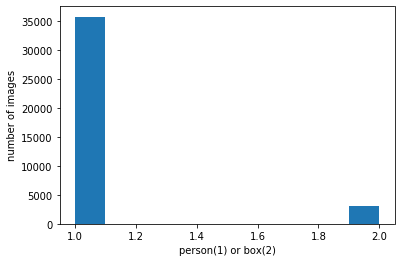

In [107]:
plt.hist(labels)
plt.xlabel("person(1) or box(2)")
plt.ylabel("number of images")

In [108]:
labels_1_idx = [index for index, label in enumerate(labels) if label==1]
labels_2_idx = [index for index, label in enumerate(labels) if label==2]

In [109]:
print(len(labels_1_idx))
print(len(labels_2_idx))

35694
3101


In [110]:
def img_show(filename):
    file = "dataset_hanmi/images/"+filename+".jpg"
    img = plt.imread(file)
    plt.imshow(img)
    plt.show()

In [111]:
import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects

def draw_rect(img_path, x1, y1, x2, y2, name=None):
    img = plt.imread(img_path)
    fig,ax = plt.subplots(1)
    fig.set_size_inches(25, 10)
    ax.imshow(img)
    rect = patches.Rectangle((x1,y1),x2-x1+1,y2-y1+1,linewidth=1,edgecolor='r',facecolor='none')    
    ax.add_patch(rect)
    if name is not None:
        txt = ax.text(x1-10, y1-10, name, color='black')
        txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    plt.show()

In [112]:
labels_1_idx = np.asarray(labels_1_idx)
labels_2_idx = np.asarray(labels_2_idx)
bboxs = np.asarray(bboxs)
filenames = np.asarray(filenames)

In [117]:
person_filenames = filenames[labels_1_idx]

In [118]:
box_filenames = filenames[labels_2_idx]

In [119]:
person_bboxs = bboxs[labels_1_idx]

In [120]:
box_bboxs = bboxs[labels_2_idx]

In [121]:
len(labels_1_idx)

35694

In [122]:
len(person_filenames)

35694

In [187]:
idx = np.random.choice(len(person_filenames)-1)

In [193]:
bbox = person_bboxs[idx]
file = person_filenames[idx]

In [194]:
img_path = "dataset_hanmi/images/"+file+".jpg"

In [195]:
x1 = bbox[0]
y1 = bbox[1]
x2 = bbox[0]+bbox[2] #width
y2 = bbox[1]+bbox[3] #height

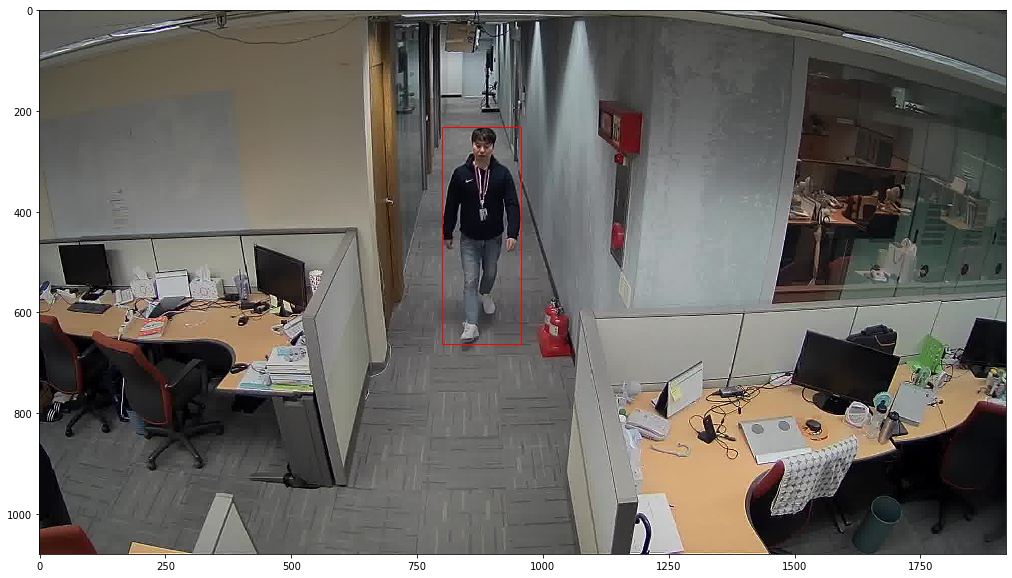

In [196]:
draw_rect(img_path, x1, y1, x2, y2)

In [197]:
wh_ratios = [bbox[3]/bbox[2] for bbox in person_bboxs]

In [198]:
len(wh_ratios)

35694

In [264]:
np.argmax(wh_ratios)

8679

In [278]:
np.mean(wh_ratios)

2.59316171567385

In [270]:
lying_idxs = [ idx for idx, ratio in enumerate(wh_ratios) if ratio<= 0.6 ]

In [279]:
lying_idxs = np.asarray(lying_idxs)

In [284]:
lying_filenames = person_filenames[lying_idxs]

In [285]:
lying_bboxs = person_bboxs[lying_idxs]

In [360]:
for file in lying_filenames:
    img_path = "dataset_hanmi/images/"+file+".jpg"
    save_path = "dataset_hanmi/labeled/1/"+file+".jpg"
    
    img = Image.open(img_path)
    img.save(save_path)

In [399]:
for idx, file in enumerate(lying_filenames):
    img_path = "dataset_hanmi/images/"+file+".jpg"
    save_path = "dataset_hanmi/cropped/1/"+file+".jpg"
    
    img = Image.open(img_path)
    bbox = lying_bboxs[idx]    
    
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = x1 + bbox[2]
    y2 = y1 + bbox[3]
    
    img = img.crop((x1,y1,x2,y2))
    img.save(save_path)

In [362]:
standing_idxs = [ idx for idx, ratio in enumerate(wh_ratios) if ratio>=2 and ratio<= 5 ]

In [364]:
standing_idxs = np.asarray(standing_idxs)

In [368]:
standing_filenames = person_filenames[standing_idxs]

In [369]:
standing_bboxs = person_bboxs[standing_idxs]

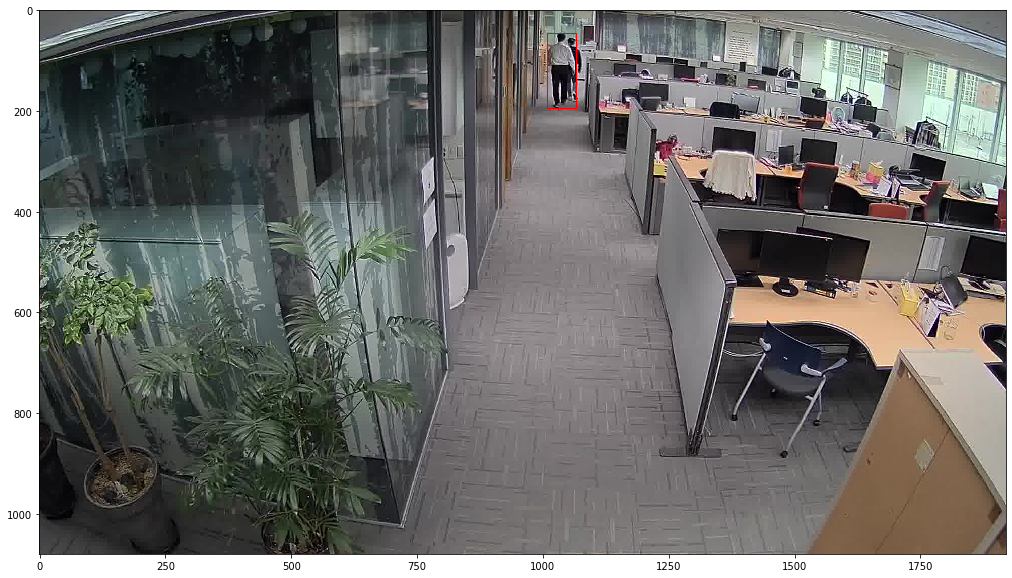

In [395]:
idx = np.random.choice(len(standing_filenames)-1)
img_path = "dataset_hanmi/images/"+standing_filenames[idx]+".jpg"
bbox = standing_bboxs[idx]
x1 = bbox[0]
y1 = bbox[1]
x2 = x1 + bbox[2]
y2 = y1 + bbox[3]
draw_rect(img_path, x1, y1, x2, y2)

In [396]:
for file in standing_filenames[:1000]:
    img_path = "dataset_hanmi/images/"+file+".jpg"
    save_path = "dataset_hanmi/labeled/0/"+file+".jpg"
    
    img = Image.open(img_path)
    img.save(save_path)

In [398]:
for idx, file in enumerate(standing_filenames[:1000]):
    img_path = "dataset_hanmi/images/"+file+".jpg"
    save_path = "dataset_hanmi/cropped/0/"+file+".jpg"
    
    img = Image.open(img_path)
    bbox = standing_bboxs[idx]    
    
    x1 = bbox[0]
    y1 = bbox[1]
    x2 = x1 + bbox[2]
    y2 = y1 + bbox[3]
    
    img = img.crop((x1,y1,x2,y2))
    img.save(save_path)